In [43]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from mplsoccer.pitch import Pitch,VerticalPitch
import statsmodels.api as sm
import statsmodels.formula.api as smf

#load german league
with open('...\events_Germany.json') as f:
    data = json.load(f)
    
#Create a data set of shots.
train = pd.DataFrame(data)
shots=train[train['subEventName']=='Shot']
shots_model=pd.DataFrame(columns=['Goal','X','Y'])


In [44]:
train

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],15231,"[{'y': 50, 'x': 50}, {'y': 48, 'x': 50}]",2516739,Pass,2446,1H,2.409746,85,179896442
1,8,Simple pass,[{'id': 1801}],14786,"[{'y': 48, 'x': 50}, {'y': 22, 'x': 22}]",2516739,Pass,2446,1H,2.506082,85,179896443
2,8,Simple pass,[{'id': 1801}],14803,"[{'y': 22, 'x': 22}, {'y': 46, 'x': 6}]",2516739,Pass,2446,1H,6.946706,85,179896444
3,8,Simple pass,[{'id': 1801}],14768,"[{'y': 46, 'x': 6}, {'y': 10, 'x': 20}]",2516739,Pass,2446,1H,10.786491,85,179896445
4,8,Simple pass,[{'id': 1801}],14803,"[{'y': 10, 'x': 20}, {'y': 4, 'x': 27}]",2516739,Pass,2446,1H,12.684514,85,179896446
...,...,...,...,...,...,...,...,...,...,...,...,...
519402,1,Ground attacking duel,"[{'id': 702}, {'id': 1801}]",15317,"[{'y': 9, 'x': 91}, {'y': 6, 'x': 90}]",2517044,Duel,2463,2H,2825.097992,11,251206867
519403,1,Ground defending duel,"[{'id': 703}, {'id': 1801}]",14804,"[{'y': 94, 'x': 10}, {'y': 95, 'x': 0}]",2517044,Duel,2451,2H,2825.519102,12,251206788
519404,1,Ground attacking duel,"[{'id': 701}, {'id': 1802}]",15317,"[{'y': 6, 'x': 90}, {'y': 5, 'x': 100}]",2517044,Duel,2463,2H,2826.053788,11,251206868
519405,8,Simple pass,[{'id': 1802}],14804,"[{'y': 95, 'x': 0}, {'y': 93, 'x': 5}]",2517044,Pass,2451,2H,2828.080925,85,251206790


In [45]:
#Calculate X, Y co-ordinates
#Distance from a line in the centre
#Shot angle.
for i,shot in shots.iterrows():
    
    header=0
    for shottags in shot['tags']:
        if shottags['id']==403:
            header=1
    #Only include non-headers        
    if not(header):        
        shots_model.at[i,'X']=100-shot['positions'][0]['x']
        shots_model.at[i,'Y']=shot['positions'][0]['y']
        shots_model.at[i,'C']=abs(shot['positions'][0]['y']-50)
    
        #Distance in metres and shot angle in radians.
        x=shots_model.at[i,'X']*105/100
        y=shots_model.at[i,'C']*65/100
        shots_model.at[i,'Distance']=np.sqrt(x**2 + y**2)
        a = np.arctan(7.32 *x /(x**2 + y**2 - (7.32/2)**2))
        if a<0:
            a=np.pi+a
        shots_model.at[i,'Angle'] =a
    
        #Whether it is a goal
        shots_model.at[i,'Goal']=0
        for shottags in shot['tags']:
                #Tags contain that its a goal
                if shottags['id']==101:
                    shots_model.at[i,'Goal']=1

In [46]:
#Two dimensional histogram
H_Shot=np.histogram2d(shots_model['X'], shots_model['Y'],bins=50,range=[[0, 100],[0, 100]])
goals_only=shots_model[shots_model['Goal']==1]
H_Goal=np.histogram2d(goals_only['X'], goals_only['Y'],bins=50,range=[[0, 100],[0, 100]])

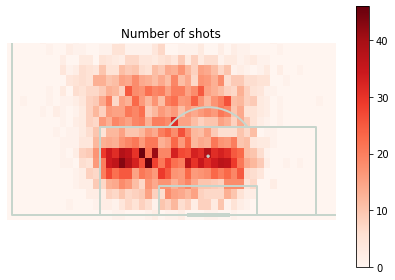

In [47]:
#Plot the number of shots from different points
pitch =  VerticalPitch(pitch_type = 'statsbomb', tight_layout = True,
              pitch_color = 'white', line_color = '#c7d5cc', figsize = (16,11))
fig, ax = pitch.draw()

pos=ax.imshow(H_Shot[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
ax.set_title('Number of shots')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')

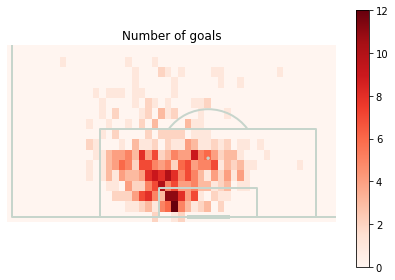

In [48]:
#Plot the number of GOALS from different points
pitch = VerticalPitch(pitch_type = 'statsbomb', tight_layout = True,
              pitch_color = 'white', line_color = '#c7d5cc', figsize = (16, 11))
fig, ax = pitch.draw()

pos=ax.imshow(H_Goal[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
ax.set_title('Number of goals')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')

<ipython-input-49-e29928364e89>:6: RuntimeWarning: invalid value encountered in true_divide
  pos=ax.imshow(H_Goal[0]/H_Shot[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=0.5)


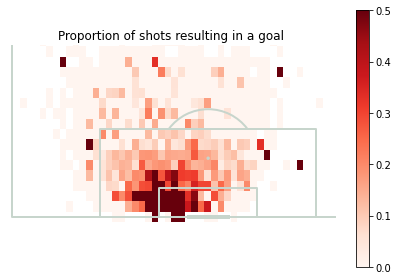

In [49]:
#Plot the probability of scoring from different points
pitch = VerticalPitch(pitch_type = 'statsbomb', tight_layout = True,
              pitch_color = 'white', line_color = '#c7d5cc', figsize = (16, 11))
fig, ax = pitch.draw()

pos=ax.imshow(H_Goal[0]/H_Shot[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=0.5)
fig.colorbar(pos, ax=ax)
ax.set_title('Proportion of shots resulting in a goal')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box') 

In [50]:
shots_model

,Goal,X,Y,C,Distance,Angle
104,0,17,66,16.0,20.658715,0.306140
216,0,9,66,16.0,14.052135,0.359480
220,0,12,49,1.0,12.616755,0.564081
313,0,26,42,8.0,27.790826,0.257467
379,0,6,66,16.0,12.159359,0.330413
...,...,...,...,...,...,...
518873,0,11,27,23.0,18.891929,0.241328
518898,0,14,63,13.0,16.955604,0.374090
519105,0,30,38,12.0,32.451348,0.218244
519379,1,9,30,20.0,16.071792,0.275279


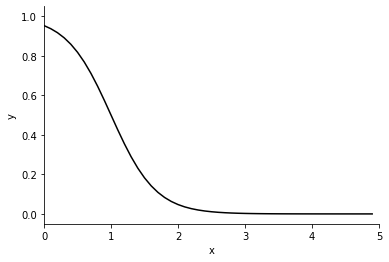

In [51]:
#Plot a logistic curve
b=[3, -3]
x=np.arange(5,step=0.1)
y=1/(1+np.exp(-b[0]-b[1]*x))
fig,ax=plt.subplots(num=1)
plt.ylim((-0.05,1.05))
plt.xlim((0,5))
ax.set_ylabel('y')
ax.set_xlabel("x") 
ax.plot(x, y, linestyle='solid', color='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

[Text(0, 0, 'No'), Text(0, 1, 'Yes')]

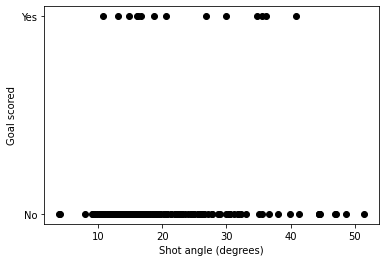

In [52]:
#Get first 200 shots
shots_200=shots_model.iloc[:200]

#Plot first 200 shots goal angle
fig,ax=plt.subplots(num=1)
ax.plot(shots_200['Angle']*180/np.pi, shots_200['Goal'], linestyle='none', marker= '.', markerSize= 12, color='black')
ax.set_ylabel('Goal scored')
ax.set_xlabel("Shot angle (degrees)")
plt.ylim((-0.05,1.05))
ax.set_yticks([0,1])
ax.set_yticklabels(['No','Yes'])

<ipython-input-53-a482550a2713>:4: RuntimeWarning: invalid value encountered in true_divide
  prob_goal=np.divide(goalcount_dist[0],shotcount_dist[0])


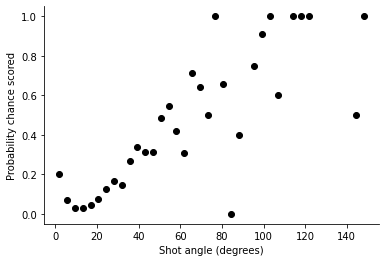

In [53]:
#Show empirically how goal angle predicts probability of scoring
shotcount_dist=np.histogram(shots_model['Angle']*180/np.pi,bins=40,range=[0, 150])
goalcount_dist=np.histogram(goals_only['Angle']*180/np.pi,bins=40,range=[0, 150])
prob_goal=np.divide(goalcount_dist[0],shotcount_dist[0])
angle=shotcount_dist[1]
midangle= (angle[:-1] + angle[1:])/2
fig,ax=plt.subplots(num=2)
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', markerSize= 12, color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Shot angle (degrees)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [54]:
#Now try sigmoid model
b=[3, -3]
x=np.arange(150,step=0.1)
y=1/(1+np.exp(b[0]+b[1]*x*np.pi/180)) 
ax.plot(x, y, linestyle='solid', color='black')

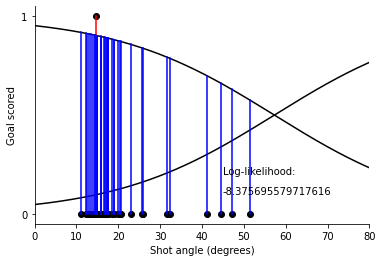

In [55]:
#Now lets look at the likelihood of model given data
xG=1/(1+np.exp(b[0]+b[1]*shots_model['Angle'])) 
shots_model = shots_model.assign(xG=xG)
shots_40=shots_model.iloc[:40]
fig,ax=plt.subplots(num=1)
ax.plot(shots_40['Angle']*180/np.pi, shots_40['Goal'], linestyle='none', marker= '.', markerSize= 12, color='black')
ax.plot(x, y, linestyle='solid', color='black')
ax.plot(x, 1-y, linestyle='solid', color='black')
loglikelihood=0
for item,shot in shots_40.iterrows():
    ang=shot['Angle']*180/np.pi
    if shot['Goal']==1:
        loglikelihood=loglikelihood+np.log(shot['xG'])
        ax.plot([ang,ang],[shot['Goal'],shot['xG']], color='red')
    else:
        loglikelihood=loglikelihood+np.log(1 - shot['xG'])
        ax.plot([ang,ang],[shot['Goal'],1-shot['xG']], color='blue')
    
ax.set_ylabel('Goal scored')
ax.set_xlabel("Shot angle (degrees)")
plt.ylim((-0.05,1.05))
plt.xlim((0,80))
plt.text(45,0.2,'Log-likelihood:') 
plt.text(45,0.1,str(loglikelihood))
ax.set_yticks([0,1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)   

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 5762
Model:                                GLM   Df Residuals:                     5760
Model Family:                    Binomial   Df Model:                            1
Link Function:                      logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -1641.3
Date:                    Mon, 14 Jun 2021   Deviance:                       3282.5
Time:                            11:16:45   Pearson chi2:                 5.71e+03
No. Iterations:                         6                                         
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

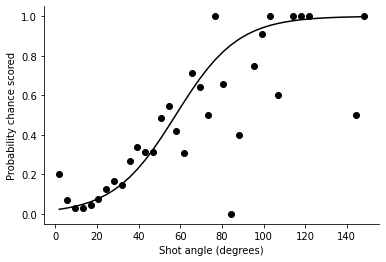

In [56]:
#Make single variable model of angle
#Using logistic regression we find the optimal values of b
#This process minimizes the loglikelihood
test_model = smf.glm(formula="Goal ~ Angle" , data=shots_model, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=test_model.params


xGprob=1/(1+np.exp(b[0]+b[1]*midangle*np.pi/180)) 
fig,ax=plt.subplots(num=1)
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', markerSize= 12, color='black')
ax.plot(midangle, xGprob, linestyle='solid', color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Shot angle (degrees)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 5762
Model:                                GLM   Df Residuals:                     5760
Model Family:                    Binomial   Df Model:                            1
Link Function:                      logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -1634.1
Date:                    Mon, 14 Jun 2021   Deviance:                       3268.1
Time:                            11:16:46   Pearson chi2:                 2.18e+07
No. Iterations:                         7                                         
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

<ipython-input-57-2965b900b81b>:5: RuntimeWarning: invalid value encountered in true_divide
  prob_goal=np.divide(goalcount_dist[0],shotcount_dist[0])


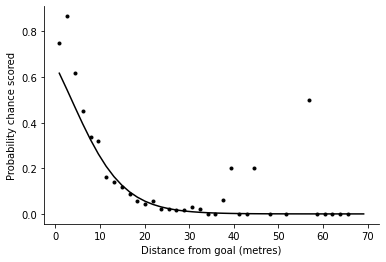

In [57]:
#Now lets look at distance from goal
#Show empirically how distance from goal predicts probability of scoring
shotcount_dist=np.histogram(shots_model['Distance'],bins=40,range=[0, 70])
goalcount_dist=np.histogram(goals_only['Distance'],bins=40,range=[0, 70])
prob_goal=np.divide(goalcount_dist[0],shotcount_dist[0])
distance=shotcount_dist[1]
middistance= (distance[:-1] + distance[1:])/2
fig,ax=plt.subplots(num=1)
ax.plot(middistance, prob_goal, linestyle='none', marker= '.', color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Distance from goal (metres)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


#Make single variable model of distance
test_model = smf.glm(formula="Goal ~ Distance" , data=shots_model, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=test_model.params
xGprob=1/(1+np.exp(b[0]+b[1]*middistance)) 
ax.plot(middistance, xGprob, linestyle='solid', color='black')   

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 5762
Model:                                GLM   Df Residuals:                     5759
Model Family:                    Binomial   Df Model:                            2
Link Function:                      logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -1601.9
Date:                    Mon, 14 Jun 2021   Deviance:                       3203.7
Time:                            11:16:46   Pearson chi2:                 6.99e+03
No. Iterations:                         6                                         
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

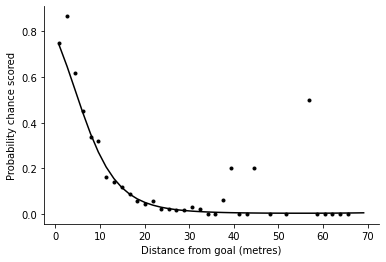

In [58]:
#Adding distance squared
squaredD = shots_model['Distance']**2
shots_model = shots_model.assign(D2=squaredD)
test_model = smf.glm(formula="Goal ~ Distance + D2" , data=shots_model, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=test_model.params
xGprob=1/(1+np.exp(b[0]+b[1]*middistance+b[2]*pow(middistance,2))) 
fig,ax=plt.subplots(num=1)
ax.plot(middistance, prob_goal, linestyle='none', marker= '.', color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Distance from goal (metres)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.plot(middistance, xGprob, linestyle='solid', color='black')